In [1]:
import pandas as pd
from tqdm.auto import tqdm
import random
import torch
from collections import defaultdict
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from transformers import BertTokenizer,BertModel

In [2]:
!pip install lightning
!pip install torchmetrics
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:0000:01


In [3]:
from huggingface_hub import notebook_login

notebook_login()

# **Dataset**

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

from huggingface_hub import notebook_login

notebook_login()

In [5]:
from huggingface_hub import notebook_login

notebook_login()


In [6]:

data = pd.read_csv('/kaggle/input/aspect-data/aspect_based_data.csv')
products = []
for idx,(product, group_data) in tqdm(enumerate(data.groupby("product"))):
    products.append(product)
random.shuffle(products)

train_ratio = 0.75
val_ratio = 0.15

size = len(products)

train = data.loc[data['product'].isin(products[:int(size*train_ratio)])]
val = data.loc[data['product'].isin(products[int(size*train_ratio):int(size*(train_ratio+val_ratio))])]
test = data.loc[data['product'].isin(products[int(size*(train_ratio+val_ratio)):])]

print(f"Number of train products: {len(train.groupby('product'))} --- Size: {len(train)}")
print(f"Number of validation products: {len(val.groupby('product'))} --- Size: {len(val)}")
print(f"Number of test products: {len(test.groupby('product'))} --- Size: {len(test)}")

0it [00:00, ?it/s]

Number of train products: 21 --- Size: 732
Number of validation products: 5 --- Size: 197
Number of test products: 3 --- Size: 71


In [7]:
token_len = []

for idx,row in data.iterrows():
    cm = row['comment'].replace("'", "").strip("][").split(', ') # convert str to list
    token_len.append(len(cm))
    
    
token_len = torch.tensor(token_len).float()

print(f"Mean: {token_len.mean()} Std: {token_len.std()}")
# select max length = 100 

Mean: 36.733001708984375 Std: 25.539146423339844


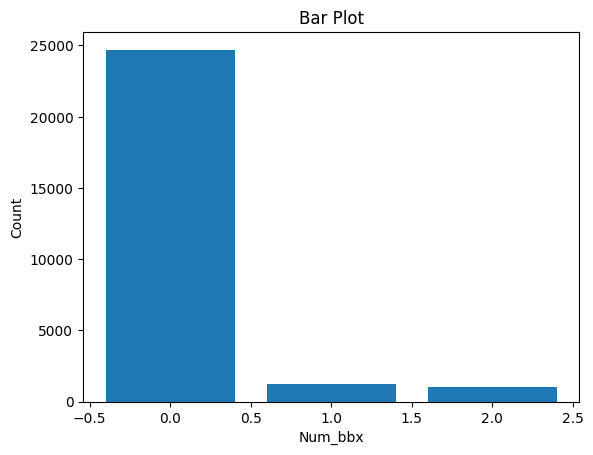

In [8]:
# statistic
count = defaultdict(lambda:0)
for idx,row in train.iterrows():
    cm = row['aspect_tag'].replace("'", "").strip("][").split(', ') # convert str to list
    labels = [int(i) for i in cm]
    for label in labels:
        count[label] +=1
    

plt.bar(count.keys(), count.values())
plt.xlabel('Num_bbx')
plt.ylabel('Count')
plt.title('Bar Plot')
plt.show()

In [9]:
import torch
from torch.utils.data import Dataset

class ABSADataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        print("Pad_token_id",self.tokenizer.pad_token_id)

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, 1:].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').replace("'", "").split(', ')
        pols = pols.strip('][').replace("'", "").split(', ')

        bert_tokens = []
        bert_tags = []
        bert_pols = []
        # 1: B-Aspect 2: I-Aspect 0: others
        for i in range(len(tokens)):
            # one word can be incorporated by many tokens
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            if int(tags[i]) != 0:
                bert_tags += [int(tags[i])] + [2]*(len(t)-1)
            else:
                 bert_tags += [0]*len(t)
            bert_pols += [int(pols[i])]*len(t)

        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        tags_tensor = torch.tensor(bert_tags)
        pols_tensor = torch.tensor(bert_pols)
        return bert_tokens, ids_tensor, tags_tensor, pols_tensor

    def __len__(self):
        return len(self.df)

# Build model

In [13]:
from transformers import BertModel
from torch import nn
import torch
from torch.utils.data import Dataset , DataLoader
from huggingface_hub import PyTorchModelHubMixin

class ABTEBert(nn.Module,PyTorchModelHubMixin):
    def __init__(self,dropout = 0.5):
        super(ABTEBert,self).__init__()
        self.feature_extractor = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.head = nn.Linear(768,3)
        self.drop = nn.Dropout(dropout)
    def forward(self, ids_tensors, masks_tensors = None):
        outputs = self.feature_extractor(input_ids=ids_tensors, attention_mask=masks_tensors)
        cls_token = outputs.last_hidden_state
        y = self.head(self.drop(cls_token)) # bs,l,d
        return y.permute(0,2,1)

In [14]:
from torch.nn.utils.rnn import pad_sequence

def padding(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True,padding_value=0)

    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True,padding_value=100)

    pols_tensors = [s[3] for s in samples]
    pols_tensors = pad_sequence(pols_tensors, batch_first=True,padding_value=0)

    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, tags_tensors, pols_tensors, masks_tensors


In [15]:
import lightning.pytorch as L
from torchmetrics.functional import accuracy, f1_score
class ABTEBert_Module(L.LightningModule):
    def __init__(self,train_data,val_data,test_data,lr,weight_decay,max_epochs,**kwargs):
        self.save_hyperparameters()
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        total = count[0] + count[1] + count[2]
        weight = [
            1 - count[0]/total,
            1 - count[1]/total,
            1 - count[2]/total
        ]
        print(weight)
#         self.loss_func = nn.CrossEntropyLoss(ignore_index = 100,weight = torch.tensor(weight))
        self.loss_func = nn.CrossEntropyLoss(ignore_index = 100)
        self.model = ABTEBert()
        self.num_classes = n_classes
    def setup(self, stage: str):
        if stage == "fit":
            self.train_dataset = ABSADataset(
                self.train_data
                )
            self.val_dataset = ABSADataset(
                self.val_data
                )
        if stage == "test":
            self.test_dataset = ABSADataset(
                self.test_data 
                )
    def forward(self,ids_tensors, masks_tensors):
        return self.model(ids_tensors, masks_tensors)

    def training_step(self, batch, batch_idx):
        ids_tensors, tags_tensors, pols_tensors, masks_tensors = batch
        y = tags_tensors
        y_hat = self(ids_tensors, masks_tensors)
        loss = self.loss_func(y_hat, y)       
        y_pred = torch.softmax(y_hat, dim=1)

        # Logging to TensorBoard by default
        self.log("train_loss", loss, prog_bar=True,on_step=True, on_epoch=True)
        self.log("train_acc", accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes,ignore_index = 100), prog_bar=True,on_step=True, on_epoch=True)
        self.log("train_f1", f1_score(y_pred,y,average = 'macro', task="multiclass", num_classes=self.num_classes,ignore_index=100), prog_bar=True,on_step=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ids_tensors, tags_tensors, pols_tensors, masks_tensors = batch
        y = tags_tensors
        y_hat = self(ids_tensors, masks_tensors)
        loss = self.loss_func(y_hat, y)

        y_pred = torch.softmax(y_hat, dim=1)
       
        
        # Logging to TensorBoard by default
        self.log("val_loss", loss, prog_bar=True,on_step=False, on_epoch=True)
        self.log("val_acc", accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes,ignore_index=100), prog_bar=True,on_step=False, on_epoch=True)
        self.log("val_f1", f1_score(y_pred, y,average = 'macro', task="multiclass", num_classes=self.num_classes,ignore_index=100), prog_bar=True,on_step=False, on_epoch=True)

        return loss
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        ids_tensors, tags_tensors, pols_tensors, masks_tensors = batch
        y = tags_tensors
        y_hat = self(ids_tensors, masks_tensors)
        y_pred = torch.softmax(y_hat, dim=1)

        self.log("test_acc", accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes,ignore_index=100), prog_bar=True,on_step=False, on_epoch=True)
        self.log("test_f1", f1_score(y_pred, y,average = 'macro', task="multiclass", num_classes=self.num_classes,ignore_index=100), prog_bar=True,on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        if self.max_epochs is not None:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer=optimizer,step_size = 10, gamma=0.7
            )
            return [optimizer], [lr_scheduler]
        else:
            return optimizer
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=16,shuffle = True,collate_fn=padding)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=16,collate_fn=padding)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=16,collate_fn=padding)
        

In [16]:
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from  lightning.pytorch.callbacks import ModelCheckpoint

lr = 1e-5
weight_decay = 0.05
max_epochs = 60
n_classes = 3 # Positive or Negative

trainer = L.Trainer(
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min",min_delta=0.00, patience=15,check_finite = True ),
        ModelCheckpoint(dirpath="/kaggle/working/", save_top_k=1, monitor="val_loss",save_last = True)
              ],
    max_epochs=max_epochs,
    accelerator="auto", devices='auto',
    gradient_clip_val=1,
    log_every_n_steps = 1
)
model = ABTEBert_Module(train,val,test,lr,weight_decay,max_epochs,count = count)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


[0.08317874897974331, 0.9543666988202122, 0.9624545522000445]


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [17]:
trainer.fit(model)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'count' removed from hparams because it cannot be pickled
2024-05-28 08:35:16.347889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 08:35:16.348008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 08:35:16.489318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Pad_token_id 0


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pad_token_id 0


INFO: 
  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | ABTEBert         | 177 M 
-----------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.423   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [18]:
trainer.test(model,ckpt_path = '/kaggle/working/epoch=13-step=644.ckpt')

INFO: Restoring states from the checkpoint path at /kaggle/working/epoch=13-step=644.ckpt


Pad_token_id 0


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/epoch=13-step=644.ckpt
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9367564916610718     │
│          test_f1          │    0.7182676792144775     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9367564916610718, 'test_f1': 0.7182676792144775}]

In [19]:
model = ABTEBert_Module.load_from_checkpoint("/kaggle/working/epoch=13-step=644.ckpt")
# save locally
model.model.save_pretrained("Aspect_Based_Term_Extraction_for_Reviews")

# push to the hub
model.model.push_to_hub("Aspect_Based_Term_Extraction_for_Reviews")

[0.08317874897974331, 0.9543666988202122, 0.9624545522000445]


model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NCTuanAnh/Aspect_Based_Term_Extraction_for_Reviews/commit/d62d1e639fc84a3cd343a39c20b2d28b56157f0b', commit_message='Push model using huggingface_hub.', commit_description='', oid='d62d1e639fc84a3cd343a39c20b2d28b56157f0b', pr_url=None, pr_revision=None, pr_num=None)

In [20]:
def predict(model,sentence, device = 'cpu'):
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    sentence = sentence.strip().lower().split(" ")
    tag = []
    words = []
    for idx,word in enumerate(sentence):
        word = tokenizer.tokenize(word)
        tag.extend([idx+1]*len(word))
        words.extend(tokenizer.convert_tokens_to_ids(word))
    tag = torch.tensor(tag)
    with torch.no_grad():
        outputs = model(torch.tensor(words).unsqueeze(dim = 0), None)
        predictions = outputs.permute(0,2,1).argmax(dim = -1)
        

    predictions = predictions[0]
    prediction = []
    for idx,word in enumerate(sentence):
        pd = predictions[idx + 1 == tag]
        if 1 in pd:
            prediction.append(1)
        elif 2 in pd:
            prediction.append(2)
        else:
            prediction.append(0)
    # get aspect
    aspect = []
    is_new_aspect = True
    k = 0
    for idx,v in enumerate(prediction):
        if not is_new_aspect:
            if v == 0:
                aspect.append(' '.join(sentence[k:idx]))
                is_new_aspect = True
        else:
            if v != 0:
                k = idx
                is_new_aspect = False            
    
    return aspect


In [21]:
model = ABTEBert.from_pretrained('NCTuanAnh/Aspect_Based_Term_Extraction_for_Reviews')
model.eval()
print()

config.json:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [23]:

text = 'Chất liệu được nha mọi người dùng rất tốt'.replace(','," ")
predict(model,text)

['chất liệu']

(['ch',
  '##án',
  'n',
  '##h',
  '##ể',
  'nhưng',
  'màu',
  'đẹp',
  'n',
  '##ha',
  'mọi',
  'người'],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])